In [23]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

Create device-agnostic code.

This means if we've got GPU, our code will use it.
If no GPU is available, the code will default to using CPU.

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device - {device}')

Using device - cuda


In [25]:
!nvidia-smi

Thu Dec  1 18:11:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    32W /  70W |    824MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Create some data using the Linear Regresssion Formula: y = mX + c

Where,
m = weight and
c = bias

In [26]:
weight = 0.7
bias = 0.3

Create range values:

In [27]:
start = 0
end = 1
step = 0.02

Create X and y (features and lables)

In [28]:
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

Split the data for training and testing

In [29]:
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

Plot the current data:

In [30]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  plt.figure(figsize=(10, 7))
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training Data")
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing Data")
  
  if predictions is not None:
    plt.scatter(test_data, predictions, c='r', s=4, label="Predictions")
  
  plt.legend(prop={"size": 14})

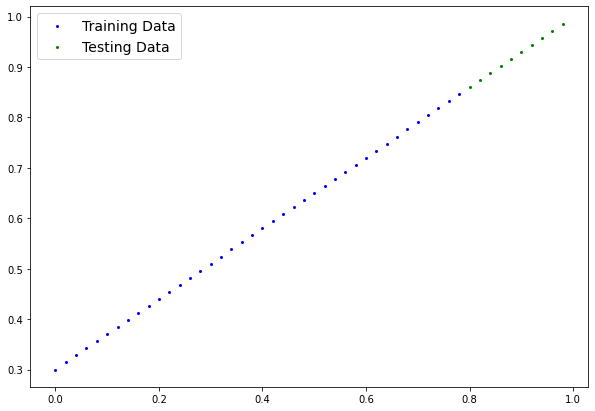

In [31]:
plot_predictions(X_train, y_train, X_test, y_test)

### Building PyTorch Linear Model:
Create a PyTorch Linear modal by subclassing nn.Module.

In [32]:
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()

    # Use nn.Linear() for creating the model parameters
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)
    
  def forward(self, X: torch.Tensor) -> torch.Tensor:
    return self.linear_layer(X)

  
torch.manual_seed(42)
model = LinearRegressionModel()
model, model.state_dict()

(LinearRegressionModel(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

### Training the Model

Check the model current device:

In [33]:
next(model.parameters()).device

device(type='cpu')

Set the model to use the target device:

In [34]:
model.to(device)
next(model.parameters()).device

device(type='cuda', index=0)

For training we need:
* Loss function
* Optimizer
* Training loop
* Testing loop

Setup Loss function & Optimizer:

In [35]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

Let's write train loop:

In [36]:
torch.manual_seed(42)

epochs = 200

# Put data on the target device
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
  # Train the Model
  model.train()

  # Forward Pass
  y_pred = model(X_train)

  # Calculate the Loss
  loss = loss_fn(y_pred, y_train)

  # Optimizer Zero Grad
  optimizer.zero_grad()

  # Perform BackPropagation
  loss.backward()

  # Optimizer Steps
  optimizer.step()


  # Testing the model
  model.eval()
  with torch.inference_mode():
    test_pred = model(X_test)

    test_loss = loss_fn(test_pred, y_test)

  # Print the result
  if epoch % 5 == 0:
    print(f'Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}')

Epoch: 0 | Loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 5 | Loss: 0.49757298827171326 | Test loss: 0.5066213011741638
Epoch: 10 | Loss: 0.439968079328537 | Test loss: 0.4392664134502411
Epoch: 15 | Loss: 0.38236314058303833 | Test loss: 0.37191149592399597
Epoch: 20 | Loss: 0.3247582018375397 | Test loss: 0.30455657839775085
Epoch: 25 | Loss: 0.267153263092041 | Test loss: 0.23720164597034454
Epoch: 30 | Loss: 0.20954833924770355 | Test loss: 0.16984669864177704
Epoch: 35 | Loss: 0.1519434005022049 | Test loss: 0.1024918332695961
Epoch: 40 | Loss: 0.09433845430612564 | Test loss: 0.03513690456748009
Epoch: 45 | Loss: 0.03738182410597801 | Test loss: 0.029703443869948387
Epoch: 50 | Loss: 0.023886388167738914 | Test loss: 0.04784907028079033
Epoch: 55 | Loss: 0.0217101089656353 | Test loss: 0.048565614968538284
Epoch: 60 | Loss: 0.019956795498728752 | Test loss: 0.045803118497133255
Epoch: 65 | Loss: 0.018237387761473656 | Test loss: 0.04166685417294502
Epoch: 70 | Lo

### Making and Evaluating the Predictions

In [37]:
model.eval()

with torch.inference_mode():
  y_preds = model(X_test)

y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

Check out our model prediction with graph:

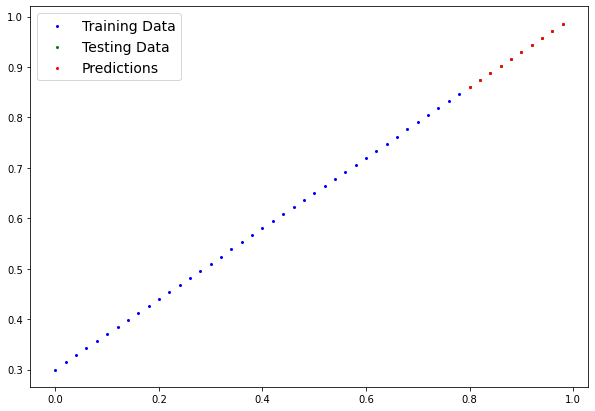

In [38]:
plot_predictions(predictions=y_preds.cpu())

### Saving and loading a trained model

In [39]:
from pathlib import Path

model_path = Path('models')
model_path.mkdir(parents=True, exist_ok=True)

model_name = "pytorch-workflow.pth"
model_save_path = model_path / model_name

model_save_path

PosixPath('models/pytorch-workflow.pth')

In [40]:
torch.save(obj=model.state_dict(), f=model_save_path)

Let's load model

In [44]:
loaded_model = LinearRegressionModel()

loaded_model.load_state_dict(torch.load(model_save_path))
loaded_model.to(device)

LinearRegressionModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [45]:
loaded_model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

Evaluate loaded model

In [46]:
loaded_model.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model(X_test)

y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

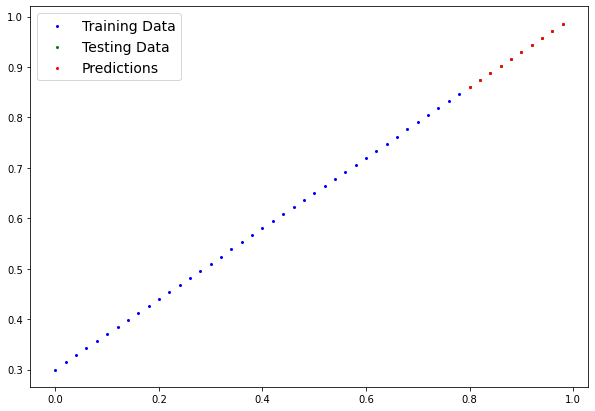

In [48]:
plot_predictions(predictions=loaded_model_preds.cpu())